## Рекомендательные системы

Мы рассмотрим основные подходы к задаче рекомендации и увидим, как это выглядит на практике на небольшом датасете.

Воспользуемся датасетом: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [1]:
%pylab inline

import pandas as pd

from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим [Deskdrop dataset](https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip), включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

In [2]:
# загружаем и разархивируем данные, для вашего удобства данные можно найти по ссылке: 
# https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip 
# в Colab и linux вам могут пригодиться утилиты wget и unzip
# такж, если вы работаете в Google Colab, устанавливаем библиотеки, которые потребуеются дальше: pyfm, catboost
####### Здесь ваш код ##########
!pip3 -q install cython
!pip3 -q install git+https://github.com/coreylynch/pyFM
!pip3 -q install catboost
!wget -q -N https://www.dropbox.com/s/p69j0d978tetktj/articles-sharing-reading-from-cit-deskdrop.zip 
!unzip -o -q articles-sharing-reading-from-cit-deskdrop.zip
!ls *.csv
################################

unzip:  cannot find or open articles-sharing-reading-from-cit-deskdrop.zip, articles-sharing-reading-from-cit-deskdrop.zip.zip or articles-sharing-reading-from-cit-deskdrop.zip.ZIP.
shared_articles.csv    users_interactions.csv


#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [3]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [4]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [5]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [6]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [7]:
# interactions_df['eventStrength'] =
####### Здесь ваш код ##########
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
################################
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [8]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


<AxesSubplot:>

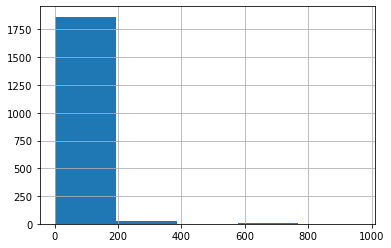

In [9]:
users_interactions_count_df.hist(bins=5)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [10]:
# interactions_from_selected_users_df =
####### Здесь ваш код ##########
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]
################################

In [11]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [12]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(20)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [13]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.25,
                                   random_state=42)

```
Как повлият такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказанями в виде списков.

In [14]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

ValueError: Must have equal len keys and value when setting with an ndarray

## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы. 

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности.

In [15]:
# popular_content = 
####### Здесь ваш код ##########
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)
################################

In [16]:
print(articles_df.loc[articles_df.contentId == popular_content[2]]['title'].values)

["Ray Kurzweil: The world isn't getting worse - our information is getting better"]


In [17]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [18]:
top_k = 10

# interactions['prediction_popular'] =
####### Здесь ваш код ##########
interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)
################################
interactions['prediction_popular'][0]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

In [43]:
def calc_precision(column):
    ####### Здесь ваш код ##########
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

    ################################

In [1]:
#calc_precision('prediction_popular')

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [21]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

### Memory-based

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [22]:
ratings_m = ratings.values

In [23]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        # similarity_users[i,j] = 
        # similarity_users[j,i] = 
        ####### Здесь ваш код ##########
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]
        ################################

<ipython-input-23-8e685abd7078>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings_m)-1)):


  0%|          | 0/1111 [00:00<?, ?it/s]

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитаем качество по той же метрике.

In [24]:
prediction_user_based = []
####### Здесь ваш код ##########
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))
################################
interactions['prediction_user_based'] = prediction_user_based

<ipython-input-24-27f095e833e5>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(similarity_users))):


  0%|          | 0/1112 [00:00<?, ?it/s]

/Users/irsafilo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

Заметим, что мы используем матрицу с нулями, будто отсутствующие взаимодействия негативные, что странно.

Если бы мы учили модель со скрытыми переменными с помощью стохастического градиентного спуска, то неизвестные взаимодействия могли бы не использовать.

In [26]:
from scipy.linalg import svd

In [27]:
####### Здесь ваш код ##########
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)
################################

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [28]:
####### Здесь ваш код ##########
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
################################

7.075035668436606e-25


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [29]:
K = 100
####### Здесь ваш код ##########
sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)
################################

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [30]:
####### Здесь ваш код ##########
new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))
################################

25843.42489891277
78622.13000466056


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [31]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []
####### Здесь ваш код ##########
for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
################################
interactions['prediction_svd'] = predictions

<ipython-input-31-e5e593b7e954>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

## Часть 3. Контентные  модели

В этой части реализуем альтернативных подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части. 

Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные.

Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [33]:
test_personId = np.repeat(interactions.index, len(ratings.columns)) 
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [34]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [35]:
# first feature index
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [36]:
test_personId = np.repeat(interactions.index, len(articles_df)) 
test_contentId = list(articles_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений contentType.

In [37]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
####### Здесь ваш код ##########
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'
################################

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова.

In [38]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
####### Здесь ваш код ##########
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())
################################

Добавим признаки-индикаторы языка.

In [39]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
####### Здесь ваш код ##########
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'
################################

Обучим на полученных признаках градиентный бустинг.

In [40]:
import catboost 

model = catboost.CatBoostClassifier()
model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.086682
0:	learn: 0.6578033	total: 68.8ms	remaining: 1m 8s
1:	learn: 0.6291562	total: 75.6ms	remaining: 37.7s
2:	learn: 0.6051830	total: 83.7ms	remaining: 27.8s
3:	learn: 0.5860451	total: 89.4ms	remaining: 22.3s
4:	learn: 0.5701578	total: 96.8ms	remaining: 19.3s
5:	learn: 0.5570634	total: 104ms	remaining: 17.2s
6:	learn: 0.5462027	total: 112ms	remaining: 15.9s
7:	learn: 0.5373478	total: 118ms	remaining: 14.7s
8:	learn: 0.5299860	total: 125ms	remaining: 13.8s
9:	learn: 0.5238030	total: 133ms	remaining: 13.2s
10:	learn: 0.5186873	total: 141ms	remaining: 12.6s
11:	learn: 0.5142827	total: 148ms	remaining: 12.2s
12:	learn: 0.5109601	total: 154ms	remaining: 11.7s
13:	learn: 0.5079288	total: 162ms	remaining: 11.4s
14:	learn: 0.5056486	total: 168ms	remaining: 11s
15:	learn: 0.5034989	total: 175ms	remaining: 10.8s
16:	learn: 0.5019302	total: 181ms	remaining: 10.5s
17:	learn: 0.5006794	total: 186ms	remaining: 10.2s
18:	learn: 0.4995602	total: 193ms	remaining: 9.98s
19:	lear

172:	learn: 0.4758886	total: 1.8s	remaining: 8.6s
173:	learn: 0.4758401	total: 1.81s	remaining: 8.6s
174:	learn: 0.4757139	total: 1.82s	remaining: 8.59s
175:	learn: 0.4756735	total: 1.83s	remaining: 8.59s
176:	learn: 0.4756181	total: 1.84s	remaining: 8.57s
177:	learn: 0.4755123	total: 1.86s	remaining: 8.57s
178:	learn: 0.4753933	total: 1.87s	remaining: 8.58s
179:	learn: 0.4753067	total: 1.88s	remaining: 8.58s
180:	learn: 0.4752459	total: 1.9s	remaining: 8.58s
181:	learn: 0.4751562	total: 1.91s	remaining: 8.57s
182:	learn: 0.4750763	total: 1.92s	remaining: 8.57s
183:	learn: 0.4750033	total: 1.93s	remaining: 8.56s
184:	learn: 0.4749092	total: 1.94s	remaining: 8.54s
185:	learn: 0.4747650	total: 1.95s	remaining: 8.55s
186:	learn: 0.4746953	total: 1.97s	remaining: 8.56s
187:	learn: 0.4746543	total: 1.98s	remaining: 8.55s
188:	learn: 0.4745760	total: 1.99s	remaining: 8.54s
189:	learn: 0.4744815	total: 2s	remaining: 8.53s
190:	learn: 0.4743510	total: 2.01s	remaining: 8.52s
191:	learn: 0.47426

347:	learn: 0.4652202	total: 3.2s	remaining: 5.99s
348:	learn: 0.4651819	total: 3.21s	remaining: 5.98s
349:	learn: 0.4651326	total: 3.21s	remaining: 5.97s
350:	learn: 0.4650989	total: 3.22s	remaining: 5.96s
351:	learn: 0.4650495	total: 3.23s	remaining: 5.94s
352:	learn: 0.4650251	total: 3.23s	remaining: 5.93s
353:	learn: 0.4649690	total: 3.24s	remaining: 5.92s
354:	learn: 0.4649131	total: 3.25s	remaining: 5.9s
355:	learn: 0.4648823	total: 3.26s	remaining: 5.89s
356:	learn: 0.4648716	total: 3.26s	remaining: 5.88s
357:	learn: 0.4648518	total: 3.27s	remaining: 5.86s
358:	learn: 0.4648332	total: 3.28s	remaining: 5.85s
359:	learn: 0.4647843	total: 3.28s	remaining: 5.84s
360:	learn: 0.4647407	total: 3.29s	remaining: 5.83s
361:	learn: 0.4646983	total: 3.3s	remaining: 5.81s
362:	learn: 0.4646670	total: 3.31s	remaining: 5.8s
363:	learn: 0.4646312	total: 3.31s	remaining: 5.79s
364:	learn: 0.4645957	total: 3.32s	remaining: 5.77s
365:	learn: 0.4645109	total: 3.33s	remaining: 5.76s
366:	learn: 0.46

514:	learn: 0.4590021	total: 4.39s	remaining: 4.13s
515:	learn: 0.4589585	total: 4.4s	remaining: 4.12s
516:	learn: 0.4589346	total: 4.4s	remaining: 4.12s
517:	learn: 0.4589065	total: 4.41s	remaining: 4.11s
518:	learn: 0.4588759	total: 4.42s	remaining: 4.09s
519:	learn: 0.4588442	total: 4.43s	remaining: 4.09s
520:	learn: 0.4588204	total: 4.43s	remaining: 4.08s
521:	learn: 0.4587743	total: 4.44s	remaining: 4.07s
522:	learn: 0.4587556	total: 4.45s	remaining: 4.06s
523:	learn: 0.4587237	total: 4.45s	remaining: 4.05s
524:	learn: 0.4587052	total: 4.46s	remaining: 4.04s
525:	learn: 0.4586946	total: 4.47s	remaining: 4.03s
526:	learn: 0.4586836	total: 4.47s	remaining: 4.01s
527:	learn: 0.4586727	total: 4.48s	remaining: 4s
528:	learn: 0.4586468	total: 4.49s	remaining: 4s
529:	learn: 0.4586343	total: 4.49s	remaining: 3.98s
530:	learn: 0.4586165	total: 4.5s	remaining: 3.98s
531:	learn: 0.4586030	total: 4.51s	remaining: 3.96s
532:	learn: 0.4585774	total: 4.51s	remaining: 3.96s
533:	learn: 0.4585541

682:	learn: 0.4545290	total: 5.59s	remaining: 2.6s
683:	learn: 0.4544808	total: 5.6s	remaining: 2.59s
684:	learn: 0.4544538	total: 5.61s	remaining: 2.58s
685:	learn: 0.4544261	total: 5.61s	remaining: 2.57s
686:	learn: 0.4544017	total: 5.62s	remaining: 2.56s
687:	learn: 0.4543811	total: 5.63s	remaining: 2.55s
688:	learn: 0.4543761	total: 5.64s	remaining: 2.54s
689:	learn: 0.4543593	total: 5.64s	remaining: 2.53s
690:	learn: 0.4543239	total: 5.65s	remaining: 2.53s
691:	learn: 0.4543047	total: 5.66s	remaining: 2.52s
692:	learn: 0.4542773	total: 5.66s	remaining: 2.51s
693:	learn: 0.4542346	total: 5.67s	remaining: 2.5s
694:	learn: 0.4542048	total: 5.68s	remaining: 2.49s
695:	learn: 0.4541417	total: 5.68s	remaining: 2.48s
696:	learn: 0.4541249	total: 5.69s	remaining: 2.47s
697:	learn: 0.4540928	total: 5.7s	remaining: 2.46s
698:	learn: 0.4540725	total: 5.71s	remaining: 2.46s
699:	learn: 0.4540609	total: 5.71s	remaining: 2.45s
700:	learn: 0.4540551	total: 5.72s	remaining: 2.44s
701:	learn: 0.45

851:	learn: 0.4509712	total: 6.79s	remaining: 1.18s
852:	learn: 0.4509567	total: 6.79s	remaining: 1.17s
853:	learn: 0.4509433	total: 6.8s	remaining: 1.16s
854:	learn: 0.4509362	total: 6.81s	remaining: 1.15s
855:	learn: 0.4509204	total: 6.82s	remaining: 1.15s
856:	learn: 0.4509104	total: 6.82s	remaining: 1.14s
857:	learn: 0.4508971	total: 6.83s	remaining: 1.13s
858:	learn: 0.4508789	total: 6.83s	remaining: 1.12s
859:	learn: 0.4508463	total: 6.84s	remaining: 1.11s
860:	learn: 0.4508300	total: 6.85s	remaining: 1.1s
861:	learn: 0.4508278	total: 6.86s	remaining: 1.1s
862:	learn: 0.4508205	total: 6.86s	remaining: 1.09s
863:	learn: 0.4508185	total: 6.87s	remaining: 1.08s
864:	learn: 0.4508081	total: 6.88s	remaining: 1.07s
865:	learn: 0.4508007	total: 6.88s	remaining: 1.06s
866:	learn: 0.4507881	total: 6.89s	remaining: 1.06s
867:	learn: 0.4507575	total: 6.9s	remaining: 1.05s
868:	learn: 0.4507253	total: 6.9s	remaining: 1.04s
869:	learn: 0.4507129	total: 6.91s	remaining: 1.03s
870:	learn: 0.450

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации. 

In [41]:
####### Здесь ваш код ##########
predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
    
interactions['prediction_content'] = tmp_predictions
################################

<ipython-input-41-833161c24e01>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

Оценим их качество.

In [42]:
# calc_precision(...)
####### Здесь ваш код ##########
calc_precision('prediction_content')
################################

TypeError: 'float' object is not iterable

## Часть 4. Факторизационная машина

Вспомним, что факторизационная машина учитывает попарные взаимодействия признаков, что приводит сразу и к использованию контента (сами признаки), и к обучению скрытых представлений (индикаторы пользователей и статей).

Попробуем факторизационные машины из библиотеки pyFM (так как можно работать прямо из питона). https://github.com/coreylynch/pyFM

In [45]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

Перейдём к обобщению матричных разложений — факторизационным машинам, которые работают могут работать с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить "айдишники" пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (id и другие) можно с помощью DictVectorizer. Например, процесс может выглядить вот так:
```python
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
y = np.repeat(1.0, X.shape[0])
fm = pylibfm.FM()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))
```

Сгенерируем таблицу с признаками в таком виде, где будут id пользователя, статьи и автора статьи и несколько признаков, которые вы сможете придумать.

In [46]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)
    ####### Здесь ваш код ##########
    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'
    ################################
    train_data.append(features)

<ipython-input-46-44d30c7c4f98>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions_train_df))):


  0%|          | 0/146645 [00:00<?, ?it/s]

Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [47]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):
        ####### Здесь ваш код ##########
        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articles_df.loc[features['contentId']]
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'
        ################################
        test_data.append(deepcopy(features))

<ipython-input-47-00c1bc62ab8b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions))):


  0%|          | 0/1112 [00:00<?, ?it/s]

Векторизуем, получим разреженные матрицы.

Мы будем обучать регрессор на силу взаимодействия, а для него нужны отрицательные примеры. Добавим некоторое количество случайных примеров как негативные (матрица взаимодействий разреженная, поэтому шансы взять как негативное взаимодействие некоторое положительное мало).

In [48]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [49]:
train_features

<246645x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 1233225 stored elements in Compressed Sparse Row format>

In [50]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

Укажем размером скрытого представления 10, сделаем 10 итераций.

In [51]:
# fm = pylibfm.FM(...
####### Здесь ваш код ##########
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')
################################
fm.fit(train_features, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.11731
-- Epoch 2
Training MSE: 0.11076
-- Epoch 3
Training MSE: 0.10950
-- Epoch 4
Training MSE: 0.10873
-- Epoch 5
Training MSE: 0.10828
-- Epoch 6
Training MSE: 0.10780
-- Epoch 7
Training MSE: 0.10713
-- Epoch 8
Training MSE: 0.10563
-- Epoch 9
Training MSE: 0.10445
-- Epoch 10
Training MSE: 0.10284
-- Epoch 11
Training MSE: 0.10160
-- Epoch 12
Training MSE: 0.10082
-- Epoch 13
Training MSE: 0.10042
-- Epoch 14
Training MSE: 0.10013
-- Epoch 15
Training MSE: 0.10034
-- Epoch 16
Training MSE: 0.09992
-- Epoch 17
Training MSE: 0.09986
-- Epoch 18
Training MSE: 0.09965
-- Epoch 19
Training MSE: 0.09896
-- Epoch 20
Training MSE: 0.09849
-- Epoch 21
Training MSE: 0.09827
-- Epoch 22
Training MSE: 0.09756
-- Epoch 23
Training MSE: 0.09706
-- Epoch 24
Training MSE: 0.09639
-- Epoch 25
Training MSE: 0.09585
-- Epoch 26
Training MSE: 0.09546
-- Epoch 27
Training MSE: 0.09493
-- Epoch 28
Tra

Предскажем и оценим качество.

In [ ]:
####### Здесь ваш код ##########
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))
################################

In [ ]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [321]:
calc_precision('fm_prediction')